In [2]:
# from utils import *
import pandas as pd
import pytz
from dateutil import parser
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_data(folder_path, skip):
    # List to hold individual DataFrames
    data_frames = []
    
    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):

        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path, skiprows=skip)
            # Append the DataFrame to the list
            data_frames.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    
    # Drop duplicate rows
    deduplicated_df = combined_df.drop_duplicates()
    
    return deduplicated_df

## Solar Radiation (DNI) Data

In [3]:
rad_path = "data/mead-solar-radiation"

rad_df = read_data(rad_path, 2)

In [4]:
rad_df['datetime'] = rad_df[['Year', 'Month', 'Day','Hour']].astype(str).agg('-'.join, axis=1)

In [5]:
rad_2022 = rad_df[rad_df.Year == 2022]

In [6]:
rad_2022.head()

,Year,Month,Day,Hour,Minute,DNI,datetime
210240,2022,1,1,0,30,0,2022-1-1-0
210241,2022,1,1,1,30,0,2022-1-1-1
210242,2022,1,1,2,30,0,2022-1-1-2
210243,2022,1,1,3,30,0,2022-1-1-3
210244,2022,1,1,4,30,0,2022-1-1-4


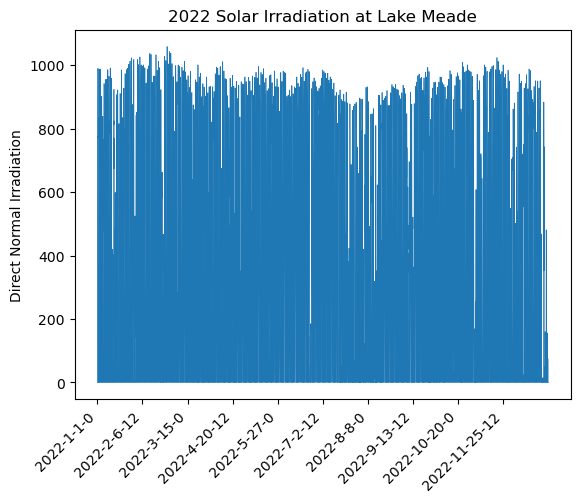

In [7]:
# Radiaton Plot
fig, ax = plt.subplots()
ax.plot(rad_2022['datetime'], rad_2022['DNI'], linewidth = .5)

# Set the frequency of x-axis labels
n_labels = 10  # Number of x-axis labels to display
step = len(rad_2022['DNI']) // n_labels
plt.xticks(np.arange(0, len(rad_2022['DNI']), step))

# Add labels and title
plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Direct Normal Irradiation")
ax.set_title('2022 Solar Irradiation at Lake Meade')

# Show the plot
plt.show()

In [8]:
np.shape(rad_2022)

(8760, 7)

## Electricity Price Data

In [8]:
# Read in Marginal Price for node at Lake Mead

price_path = "data/meads-2-N101"
df = read_data(price_path, 0)

In [10]:
df['datetimeGMT'] = df.INTERVALSTARTTIME_GMT.apply(lambda x: parser.parse(x))

# Set TZ to Pacific and convert
local_tz = pytz.timezone('US/Pacific')
df['datetime'] = df.datetimeGMT.apply(lambda x: x.replace(tzinfo=pytz.utc).astimezone(local_tz))

# Order data and extract locational marginal price (LMP)
df = df.sort_values(by='datetime')
df_LMP = df[df.XML_DATA_ITEM == 'LMP_PRC']
price_df = df_LMP[['datetime', 'OPR_DT', 'OPR_HR', 'MW']]

In [12]:
price_df.head()

,datetime,OPR_DT,OPR_HR,MW
62058,2022-01-01 00:00:00-08:00,1/1/2022,1,57.11475
62059,2022-01-01 01:00:00-08:00,1/1/2022,2,59.54397
62051,2022-01-01 02:00:00-08:00,1/1/2022,3,56.55360
62048,2022-01-01 03:00:00-08:00,1/1/2022,4,57.37142
62040,2022-01-01 04:00:00-08:00,1/1/2022,5,59.34718


Text(0.5, 1.0, '2022 Marginal Price of Electricity at Lake Meade')

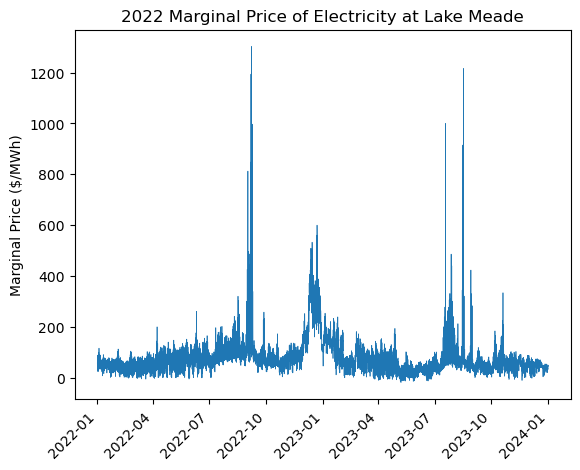

In [14]:
# Price Plot
fig, ax = plt.subplots()
ax.plot(price_df['datetime'], price_df['MW'], linewidth = .5)

# Set plot labels and title
plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_title('2022 Marginal Price of Electricity at Lake Meade')

In [16]:
np.shape(price_df)

(17520, 4)

In [18]:
365*2*24

17520

In [20]:
price_df.to_csv("price_data.csv")

## Inflow Data

In [14]:
inflow_path = "data/lees-ferry-09380000/09380000.xlsx"
sheet = "09380000"

df = pd.read_excel(inflow_path, sheet)

# convert inflow to m3/sec from ft^3/sec
df['inflow'] = df['236239-00060-00003'] / 35.315

C:\Users\Python\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


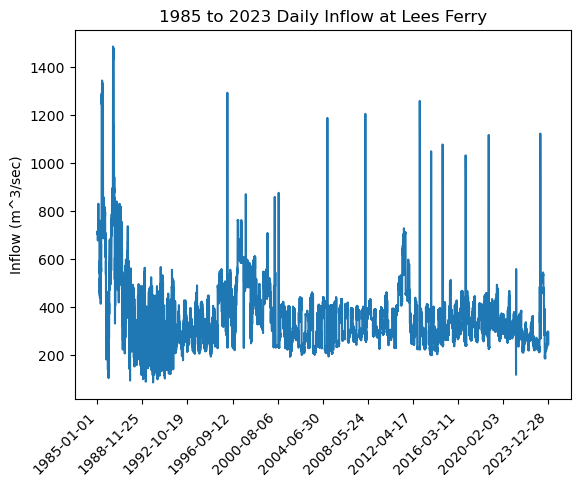

In [15]:
# Inflow Plot

plt.plot(df['DateTime'], df['inflow'])

# Set the frequency of x-axis labels
n_labels = 10  # Number of x-axis labels to display
step = len(df['inflow']) // n_labels
plt.xticks(np.arange(0, len(df['inflow']), step))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inflow (m^3/sec)')
plt.title('1985 to 2023 Daily Inflow at Lees Ferry')
plt.show()

In [16]:
inflow_path_minute = "data/lees-ferry-09380000/lakemeadepowell-inflowoutflow-15min.xlsx"
sheet = "Inflow Dataset"

In [17]:
inflow_df = pd.read_excel(inflow_path_minute, sheet)

# convert to m3/sec
inflow_df['inflow'] = inflow_df['ft^3 / second'] / 35.315

In [18]:
inflow_2022 = inflow_df[inflow_df.datetime.dt.year == 2022]
inflow_2022 = inflow_2022[inflow_2022.datetime.dt.minute == 0]

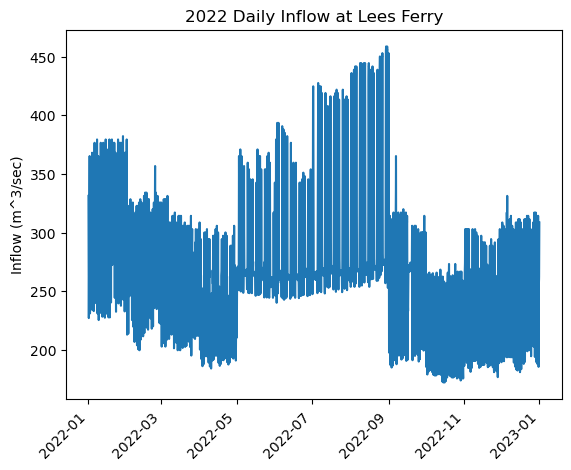

In [19]:
# Inflow Plot
plt.plot(inflow_2022['datetime'], inflow_2022['inflow'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inflow (m^3/sec)')
plt.title('2022 Daily Inflow at Lees Ferry')
plt.show()

## Combined Data Visualization

In [20]:
# All Data
df = pd.DataFrame(columns=['datetime', 'Inflow', 'SolarRad', 'Price'])
df['datetime'] = inflow_2022['datetime'].ravel()
df['Inflow'] = inflow_2022['inflow'].ravel()
df['SolarRad'] = rad_2022.DNI.ravel()
df['Price'] =  price_df['MW'].ravel()

In [21]:
x = df['datetime'].copy()
y1 = df['Inflow'].copy()
y2 = df['SolarRad'].copy() 
y3 = df['Price'].copy()

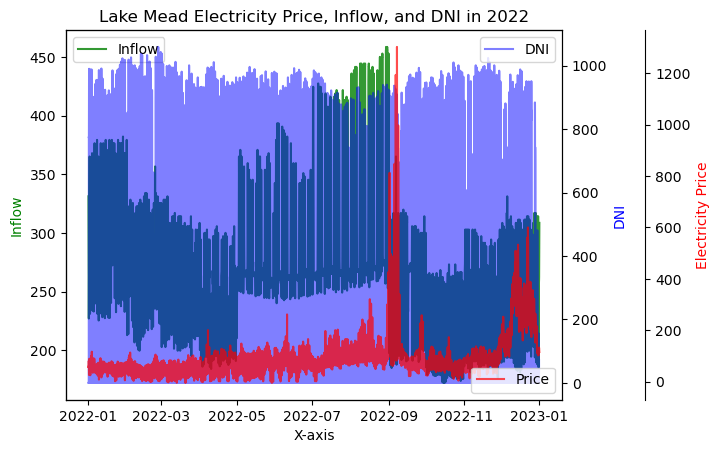

In [22]:
# Create the initial plot
fig, ax1 = plt.subplots()

# Plot the first time series
ax1.plot(x, y1, 'g-', label='Inflow', alpha=0.8)
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Inflow', color='g')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, y2, 'b-', label='DNI', alpha=0.5)
ax2.set_ylabel('DNI', color='b')

# Create a third y-axis sharing the same x-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis to the right
ax3.plot(x, y3, 'r-', label='Price', alpha=0.7)
ax3.set_ylabel('Electricity Price', color='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')

plt.title("Lake Mead Electricity Price, Inflow, and DNI in 2022")

# Show the plot
plt.show()

## Statistics

### Box Cox Normalization

In [25]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

from scipy import stats
import statsmodels.api as sm

#### Inflow

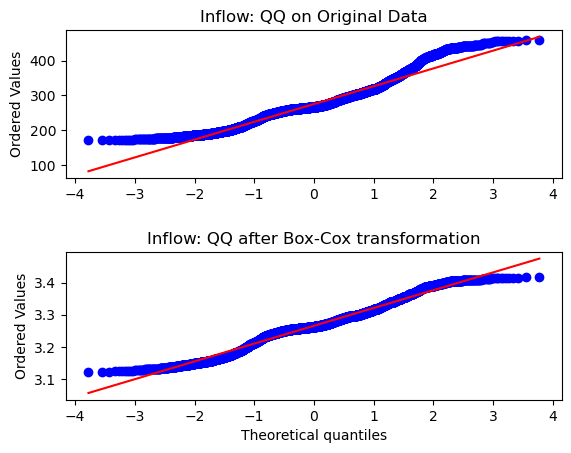

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(211)

prob = stats.probplot(y1, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Inflow: QQ on Original Data')

ax2 = fig.add_subplot(212)
y1t, lam1 = stats.boxcox(y1)
prob = stats.probplot(y1t, dist=stats.norm, plot=ax2)
ax2.set_title('Inflow: QQ after Box-Cox transformation')

plt.subplots_adjust(hspace=0.5)

plt.show()

# Tails are mildly more normally distributed?

In [52]:
lam1

-0.21357559126456757

#### Solar Radiation

In [59]:
# make sure 0s are slightly positive 
y2pos = y2 + 0.01

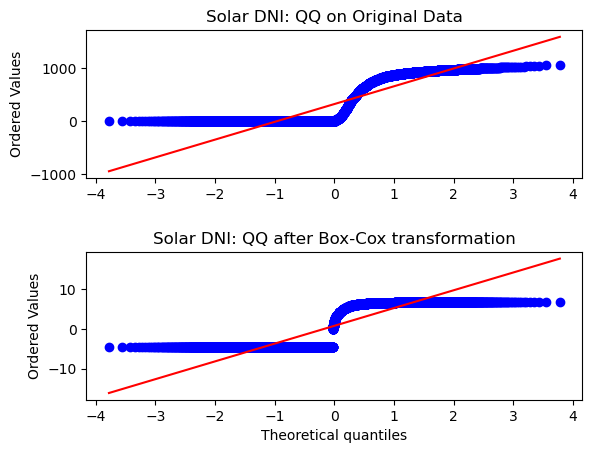

In [60]:
## Solar Rad 

fig = plt.figure()
ax1 = fig.add_subplot(211)

prob = stats.probplot(y2pos, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Solar DNI: QQ on Original Data')

ax2 = fig.add_subplot(212)
y2t, lam2 = stats.boxcox(y2pos)
prob = stats.probplot(y2t, dist=stats.norm, plot=ax2)
ax2.set_title('Solar DNI: QQ after Box-Cox transformation')

plt.subplots_adjust(hspace=0.5)

plt.show()

# Results the same :/

In [55]:
lam2

-0.004746054091859205

In [56]:
## Rerun for daytime values 
y2day = y2[y2 > 0]

In [64]:
len(y2day)/len(y2)

0.5118721461187214

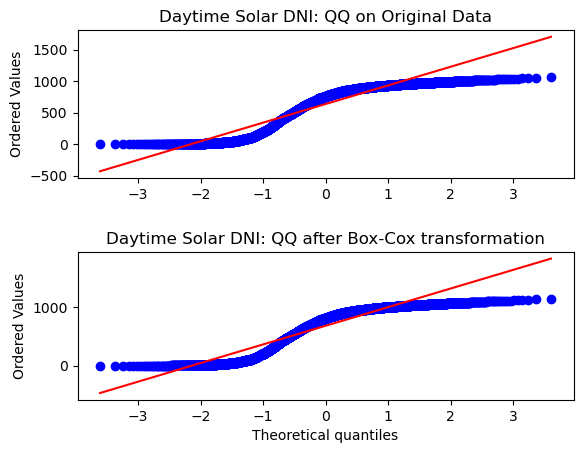

In [61]:
## Solar Rad 

fig = plt.figure()
ax1 = fig.add_subplot(211)

prob = stats.probplot(y2day, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Daytime Solar DNI: QQ on Original Data')

ax2 = fig.add_subplot(212)
y2t, lam2 = stats.boxcox(y2day)
prob = stats.probplot(y2t, dist=stats.norm, plot=ax2)
ax2.set_title('Daytime Solar DNI: QQ after Box-Cox transformation')

plt.subplots_adjust(hspace=0.5)

plt.show()

# Results the same :/

In [58]:
lam2 
# close to 1 --> no major change when transformation applied

1.012030256585412

#### Price

In [32]:
# 0.7% of data nonpositive 

# y3pos = y3[y3 > 0 ]
y3 = y3.apply(lambda x: 0.001 if x <= 0 else x)

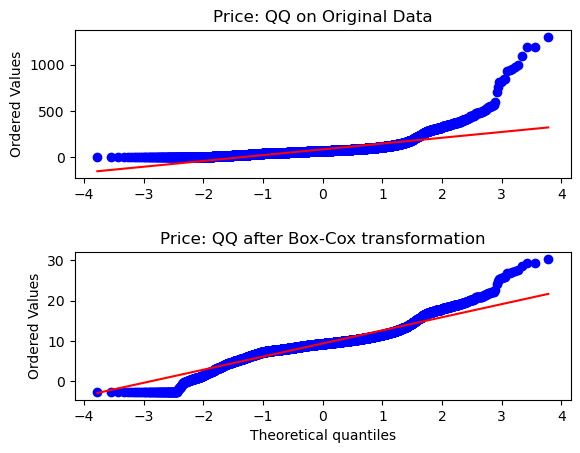

In [65]:
fig = plt.figure()
ax1 = fig.add_subplot(211)

prob = stats.probplot(y3, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Price: QQ on Original Data')

ax2 = fig.add_subplot(212)
y3t, lam3 = stats.boxcox(y3)
prob = stats.probplot(y3t, dist=stats.norm, plot=ax2)
ax2.set_title('Price: QQ after Box-Cox transformation')

plt.subplots_adjust(hspace=0.5)

plt.show()

# demonstrated improvement!

In [66]:
lam3

0.3379959105970639

In [41]:
df['NInflow'] = y1t
df['NSolarRad'] = y2t
df['NPrice'] = y3t

### Granger Casuality Test

#### Non-normalized Data

In [37]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [41]:
gc_res = grangercausalitytests(df[['SolarRad', 'Price']], 1)

# p = 0 --> reject null hypothesis --> implies casaulity between solar and price for up to lag = 10


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=58.7604 , p=0.0000  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=58.7806 , p=0.0000  , df=1
likelihood ratio test: chi2=58.5842 , p=0.0000  , df=1
parameter F test:         F=58.7604 , p=0.0000  , df_denom=8756, df_num=1


In [43]:
gc_res = grangercausalitytests(df[['SolarRad', 'Inflow']], 1)

# p = 0 --> reject null hypothesis --> implies casaulity between solar and inflow for up to lag = 10


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=908.1356, p=0.0000  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=908.4468, p=0.0000  , df=1
likelihood ratio test: chi2=864.3600, p=0.0000  , df=1
parameter F test:         F=908.1356, p=0.0000  , df_denom=8756, df_num=1


In [97]:
gc_res = grangercausalitytests(df[['Price', 'Inflow']], 1)

# p > 0.05 --> accept null hypothesis --> price and inflow not related for lag = 1, 2
# p < 0.05 --> reject null hypothesis --> price and inflow related for lag = 3, 4


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3099  , p=0.5778  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=0.3100  , p=0.5777  , df=1
likelihood ratio test: chi2=0.3100  , p=0.5777  , df=1
parameter F test:         F=0.3099  , p=0.5778  , df_denom=8756, df_num=1


#### Normalized Data

In [42]:
gc_res = grangercausalitytests(df[['NSolarRad', 'NPrice']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=215.6295, p=0.0000  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=215.7034, p=0.0000  , df=1
likelihood ratio test: chi2=213.0902, p=0.0000  , df=1
parameter F test:         F=215.6295, p=0.0000  , df_denom=8756, df_num=1


In [43]:
gc_res = grangercausalitytests(df[['NSolarRad', 'NInflow']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=873.7037, p=0.0000  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=874.0031, p=0.0000  , df=1
likelihood ratio test: chi2=833.0972, p=0.0000  , df=1
parameter F test:         F=873.7037, p=0.0000  , df_denom=8756, df_num=1


In [46]:
gc_res = grangercausalitytests(df[['NPrice', 'NInflow']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=59.1014 , p=0.0000  , df_denom=8756, df_num=1
ssr based chi2 test:   chi2=59.1216 , p=0.0000  , df=1
likelihood ratio test: chi2=58.9230 , p=0.0000  , df=1
parameter F test:         F=59.1014 , p=0.0000  , df_denom=8756, df_num=1


### Stationarity 

In [47]:
# https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [48]:
'''
Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis 
(aka the series is stationary). 
When the test statistic is greater than the critical value, we fail to reject the null hypothesis 
(which means the series is not stationary).

'''
adf_test(y1t)

# p < 0.05 --> reject null --> INFLOW is stationary

Results of Dickey-Fuller Test:
Test Statistic                   -5.298185
p-value                           0.000006
#Lags Used                       31.000000
Number of Observations Used    8728.000000
Critical Value (1%)              -3.431099
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


In [49]:
adf_test(y2t)

# p < 0.05 --> reject null --> DNI is stationary

Results of Dickey-Fuller Test:
Test Statistic                -5.764230e+00
p-value                        5.580792e-07
#Lags Used                     2.900000e+01
Number of Observations Used    8.730000e+03
Critical Value (1%)           -3.431099e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [50]:
adf_test(y3t)

# p < 0.05 --> reject null --> PRICE is stationary, but the least so of all variables!

Results of Dickey-Fuller Test:
Test Statistic                   -3.840957
p-value                           0.002515
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


## ARIMA

In [68]:
# https://github.com/adamnayak/compound_floods/blob/main/Forecast.py

def fit_arima_model(ts, max_ar=3, max_ma=3, max_d=3, plot=True):
    """
    Fits an ARIMA model to time series data and selects the best model based on AIC and BIC criteria, 
    choosing the model with fewer total parameters (AR+D+MA) if AIC and BIC criteria suggest different models.
    If the total order is the same but the models are different, it defaults to the BIC model.

    Parameters:
    - ts: The time series data as a Pandas Series.
    - max_ar: Maximum auto-regressive order to consider.
    - max_ma: Maximum moving average order to consider.
    - max_d: Maximum degree of differencing to consider.

    Returns:
    - The best ARIMA model based on the described criteria.
    """
    models_params = []
    aic_values = []
    bic_values = []

    for ar in range(1, max_ar + 1):
        for d in range(max_d + 1):
            for ma in range(1, max_ma + 1):
                try:
                    model = sm.tsa.ARIMA(ts, order=(ar, d, ma)).fit()
                    models_params.append((ar, d, ma))
                    aic_values.append(model.aic)
                    bic_values.append(model.bic)
                except Exception as e:
                    print(f"Failed to fit ARIMA({ar},{d},{ma}): {e}")
                    continue

    # Find the indices of the models with the lowest AIC and BIC
    best_aic_index = aic_values.index(min(aic_values))
    best_bic_index = bic_values.index(min(bic_values))

    # Print the models with the lowest AIC and BIC
    print(f"Model with lowest AIC: ARIMA{models_params[best_aic_index]} with AIC: {aic_values[best_aic_index]}")
    print(f"Model with lowest BIC: ARIMA{models_params[best_bic_index]} with BIC: {bic_values[best_bic_index]}")

    # Choose between AIC and BIC model based on total order, default to BIC if equal
    best_aic_order = sum(models_params[best_aic_index])
    best_bic_order = sum(models_params[best_bic_index])

    if best_aic_order < best_bic_order:
        best_model_index = best_aic_index
    else:
        # This defaults to BIC in case of a tie or BIC having fewer parameters
        best_model_index = best_bic_index

    best_params = models_params[best_model_index]
    best_model = sm.tsa.ARIMA(ts, order=best_params).fit()

    print(f"Selected model: ARIMA{best_params} with AIC: {aic_values[best_model_index]} and BIC: {bic_values[best_model_index]}")

    # Plotting original AIC and BIC values
    if plot:
        fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase figure size for better readability

        color = 'tab:red'
        ax1.set_xlabel('Model')
        ax1.set_ylabel('AIC', color=color)
        ax1.plot(range(len(models_params)), aic_values, color=color, label='AIC', marker='o')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('BIC', color=color)  # we already handled the x-label with ax1
        ax2.plot(range(len(models_params)), bic_values, color=color, label='BIC', marker='x')
        ax2.tick_params(axis='y', labelcolor=color)

        # Setting x-axis labels explicitly with rotation and alignment
        ax1.set_xticks(range(len(models_params)))  # Ensure we have a tick for each model
        ax1.set_xticklabels([f'ARIMA{params}' for params in models_params], rotation=45, ha='right', fontsize=8)

        plt.draw()  # Explicitly redraw the figure to apply the rotation and alignment
        fig.tight_layout()  # Adjust layout to make room for the rotated x-labels
        plt.title('AIC and BIC Values for Each Model')
        plt.show()

    return best_model, best_params, aic_values[best_model_index], bic_values[best_model_index]


### Train/Test Split

In [149]:
y3t_train = y3t[:-168]
y3log_train = np.log(y3[:-168])
y3_train = y3[:-168]

# Put last week of price data in test set
y3t_test = y3t[-168:]
y3log_test = np.log(y3[-168:])
y3_test = y3[-168:]

### ARIMA on Box Cox Transformed Data

In [119]:
# Box Cox Price Data
BC_arima_model, BC_params, BC_aic, BC_bic = fit_arima_model(y3t_train)

C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\base\

Model with lowest AIC: ARIMA(3, 2, 3) with AIC: 26.97060395293073
Model with lowest BIC: ARIMA(3, 2, 3) with BIC: 76.37908205777885
Selected model: ARIMA(3, 2, 3) with AIC: 26.97060395293073 and BIC: 76.37908205777885


In [142]:
BC_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8592
Model:                 ARIMA(3, 2, 3)   Log Likelihood                  -6.485
Date:                Thu, 15 Aug 2024   AIC                             26.971
Time:                        16:53:04   BIC                             76.379
Sample:                             0   HQIC                            43.822
                               - 8592                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.005    202.919      0.000       0.990       1.009
ar.L2          0.9999      0.001    745.646      0.000       0.997       1.003
ar.L3         -0.9999      0.003   -356.702      0.000      -1.005      -0.994
ma.L1         -1.0000   3.54e-07  -2.82e+06      0.000      -1.000      -1.000
ma.L2         -1.0000   1.12e-05  -8.92e+04      0.000      -1.000      -1.000
ma.L3          1.0000   7.04e-07   1.42e+06      0.000       1.000       1.000
sigma2        31.4782   1.92e-12   1.64e+13      0.000      31.478      31.478
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):       26391549135.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -92.67
Prob(H) (two-sided):                  0.00   Kurtosis:                      8588.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+34. Standard errors may be unstable.
"""

In [126]:
# Forecast the next 168 hours
forecast = BC_arima_model.forecast(steps=168)

In [133]:
from scipy.special import inv_boxcox

# Invert box cox transformed test data
y3t_inv = inv_boxcox(y3t_test, lam3)

# Invert box cox transformed forecasted data
forecast_inv = inv_boxcox(forecast, lam3)

In [136]:
# ERROR - ONLY RETURNED NANs

forecast_inv[0]

nan

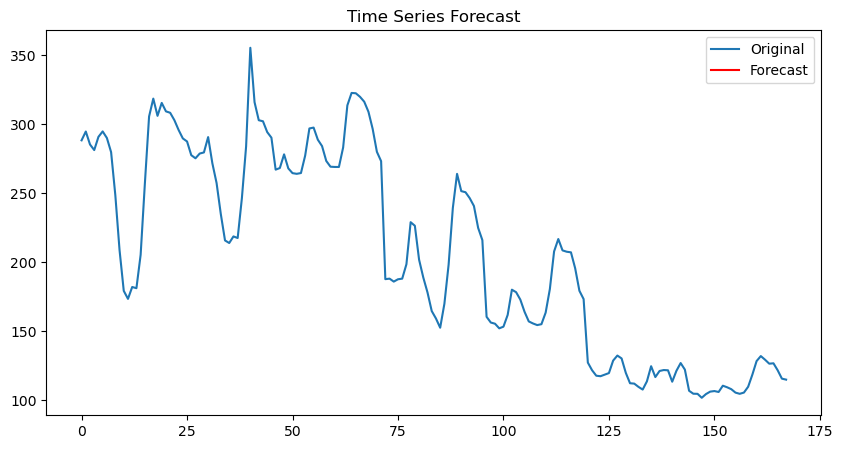

In [134]:
# Plot the forecasted values

plt.figure(figsize=(10, 5))
plt.plot(y3t_inv, label='Original')
plt.plot(forecast_inv, label='Forecast', color='red')
plt.title("Time Series Forecast")
plt.legend()
plt.show()

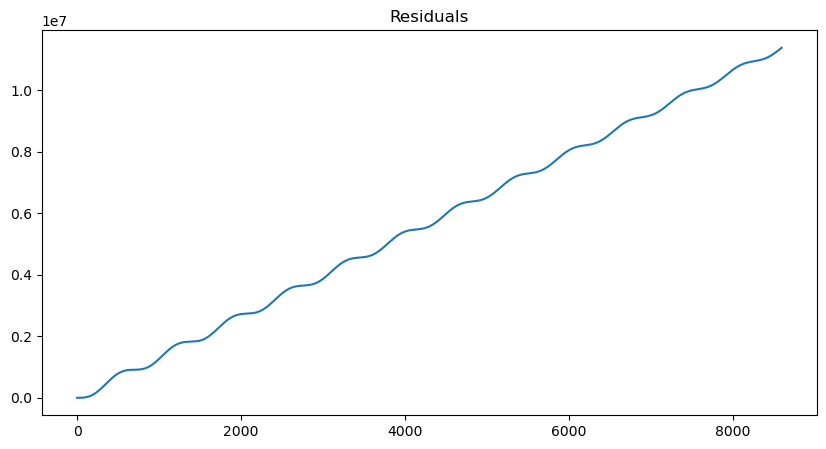

In [123]:
# Plot residuals
residuals = BC_arima_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

### ARIMA on Log Transformed Data

In [140]:
# Log Price Data
log_arima_model, log_params, log_aic, log_bic = fit_arima_model(y3log_train)

C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmod

Model with lowest AIC: ARIMA(3, 1, 3) with AIC: 9940.310637877003
Model with lowest BIC: ARIMA(3, 1, 3) with BIC: 9989.719930835468


C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Selected model: ARIMA(3, 1, 3) with AIC: 9940.310637877003 and BIC: 9989.719930835468


C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [141]:
log_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 8592
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4963.155
Date:                Thu, 15 Aug 2024   AIC                           9940.311
Time:                        16:52:51   BIC                           9989.720
Sample:                             0   HQIC                          9957.162
                               - 8592                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7274      0.018     40.120      0.000       0.692       0.763
ar.L2          0.7005      0.019     36.168      0.000       0.663       0.738
ar.L3         -0.6214      0.008    -78.483      0.000      -0.637      -0.606
ma.L1         -0.4999      0.018    -27.233      0.000      -0.536      -0.464
ma.L2         -0.8812      0.015    -60.715      0.000      -0.910      -0.853
ma.L3          0.3929      0.009     44.745      0.000       0.376       0.410
sigma2         0.1894      0.000    511.393      0.000       0.189       0.190
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):          16916629.07
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -3.64
Prob(H) (two-sided):                  0.00   Kurtosis:                       220.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
# Forecast the next 168 hours
log_forecast = log_arima_model.forecast(steps=168)

In [146]:
# Invert log transform 

log_forecast_inv = np.exp(log_forecast)
y3log_test_inv = np.exp(y3log_test)

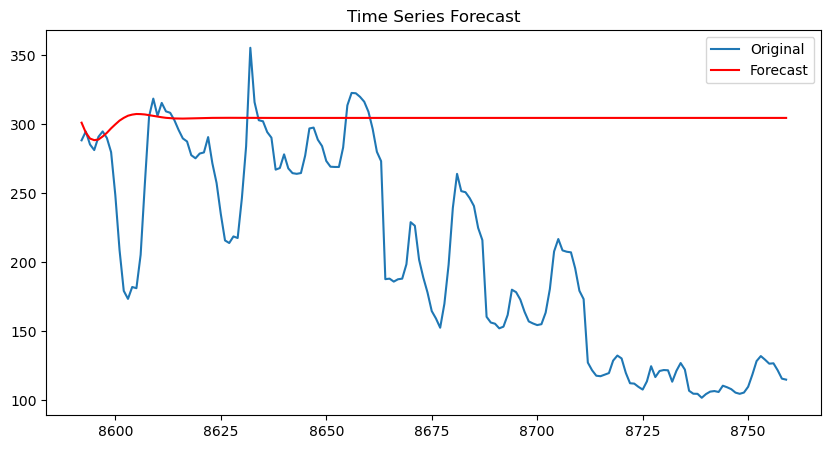

In [147]:
# Plot the forecasted values

plt.figure(figsize=(10, 5))
plt.plot(y3log_test_inv, label='Original')
plt.plot(log_forecast_inv, label='Forecast', color='red')
plt.title("Time Series Forecast")
plt.legend()
plt.show()

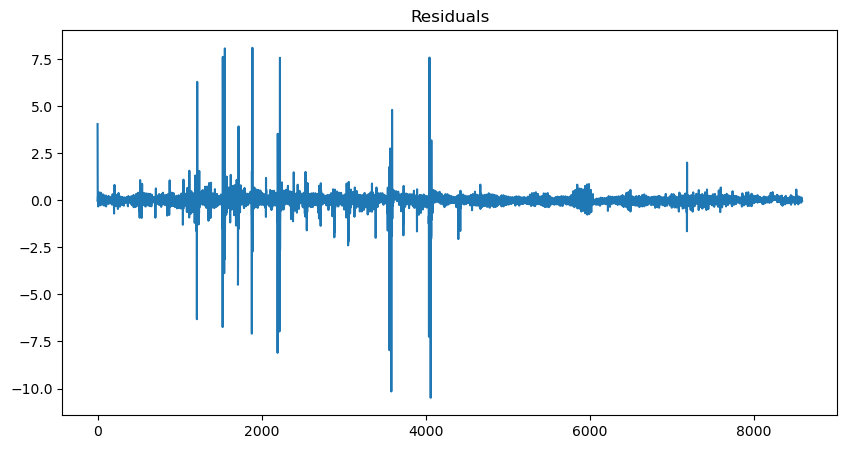

In [151]:
# Plot residuals
residuals = log_arima_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

### ARIMA on Original Data

In [150]:
arima_model, params, aic, bic = fit_arima_model(y3_train)

C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Python\anaconda3\Lib\site-packages\statsmodels\tsa\

Model with lowest AIC: ARIMA(2, 1, 3) with AIC: 75571.0698725434
Model with lowest BIC: ARIMA(2, 1, 3) with BIC: 75613.42069507923
Selected model: ARIMA(2, 1, 3) with AIC: 75571.0698725434 and BIC: 75613.42069507923


In [152]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 8592
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -37779.535
Date:                Thu, 15 Aug 2024   AIC                          75571.070
Time:                        17:17:48   BIC                          75613.421
Sample:                             0   HQIC                         75585.514
                               - 8592                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7481      0.002    804.204      0.000       1.744       1.752
ar.L2         -0.8240      0.002   -405.539      0.000      -0.828      -0.820
ma.L1         -1.3337      0.003   -472.464      0.000      -1.339      -1.328
ma.L2         -0.1548      0.004    -39.289      0.000      -0.162      -0.147
ma.L3          0.5104      0.003    178.503      0.000       0.505       0.516
sigma2       386.4315      0.853    453.190      0.000     384.760     388.103
===================================================================================
Ljung-Box (L1) (Q):                   9.02   Jarque-Bera (JB):          13282775.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.20   Skew:                             6.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       195.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
# Forecast the next 168 hours
forecast = arima_model.forecast(steps=168)

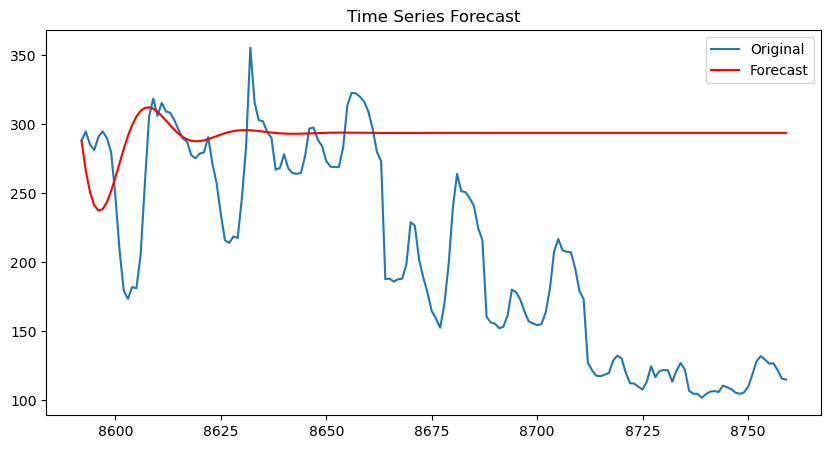

In [154]:
# Plot the forecasted values

plt.figure(figsize=(10, 5))
plt.plot(y3_test, label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.title("Time Series Forecast")
plt.legend()
plt.show()

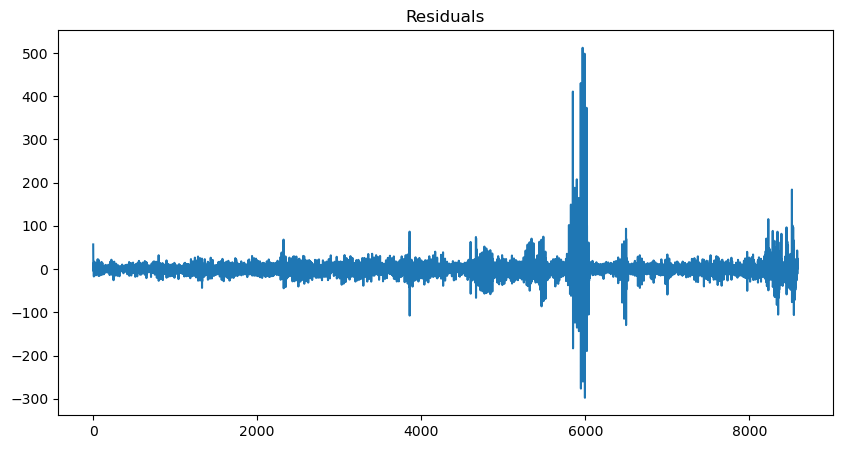

In [155]:
# Plot residuals

residuals = arima_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

## Kernel Density Estimation

In [20]:
import random
from scipy.stats import genpareto, gamma, expon, poisson
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm, rankdata
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.neighbors import NearestNeighbors
from scipy.stats import genpareto, gamma, expon, kstest, chisquare

In [30]:
def fit_logspline_density(data, n_samples, label, model=None, plot=True):
    """
    Fits a logspline density estimator to the given univariate data, samples from it,
    and optionally plots the density estimation.

    Parameters:
    data (array-like): The univariate data for which to estimate the density function.
    n_samples (int): Number of samples to draw.
    plot (bool): If True, plot the density estimation against the histogram of the data.

    Returns:
    dict: A dictionary containing the model, sample array, density function, and plot (if created).
    """
    if model == None:
        # Fit the logspline model to the data
        model = KDEMultivariate(data, var_type='c', bw='cv_ml')
    
    # Define the density function
    def density_function(x):
        return model.pdf(x)

    # Compute the CDF from the PDF
    x = np.linspace(data.min(), data.max(), 1000)
    pdf_values = density_function(x)
    cdf_values = cumtrapz(pdf_values, x, initial=0)
    cdf_values /= cdf_values[-1]  # Normalize to make it a proper CDF

    # Create an interpolation of the inverse CDF
    inverse_cdf = interp1d(cdf_values, x, bounds_error=False, fill_value=(x[0], x[-1]))

    # Draw uniform random samples for inverse transform sampling
    uniform_samples = np.random.rand(n_samples)
    samples = inverse_cdf(uniform_samples)

    # Optionally plot the density estimation
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, pdf_values, label='Density Estimate')
        plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Data')
        plt.hist(samples, bins=30, density=True, alpha=0.5, label='Histogram of Samples', color='red')
        plt.title(label + 'Kernal Density Estimation')
        plt.legend()
        plt.show()
        
    return model, samples, "Logspline"

In [26]:
n_samples = len(df['Price'].values) 
n_samples # 8760

8760

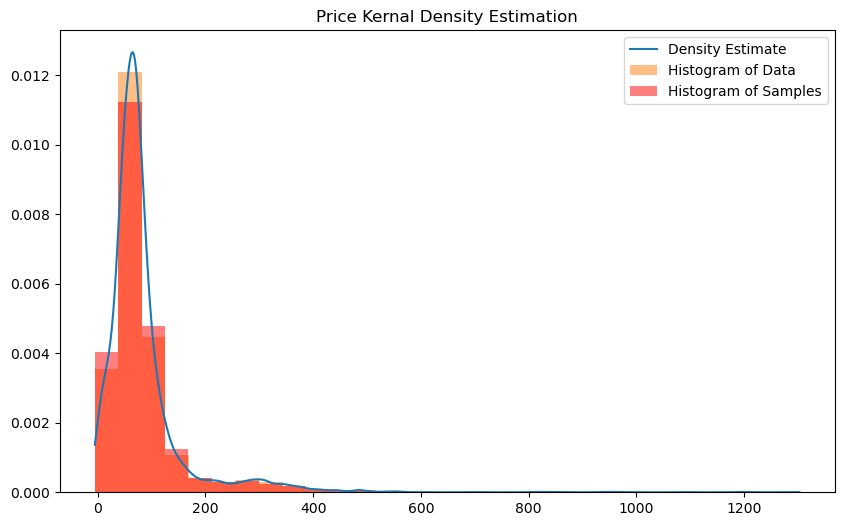

In [34]:
_, LMP_samples, _ = fit_logspline_density(df['Price'], n_samples, 'Price ', model=None, plot=True) 

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: divide by zero encountered in log
  L += func(f_i)


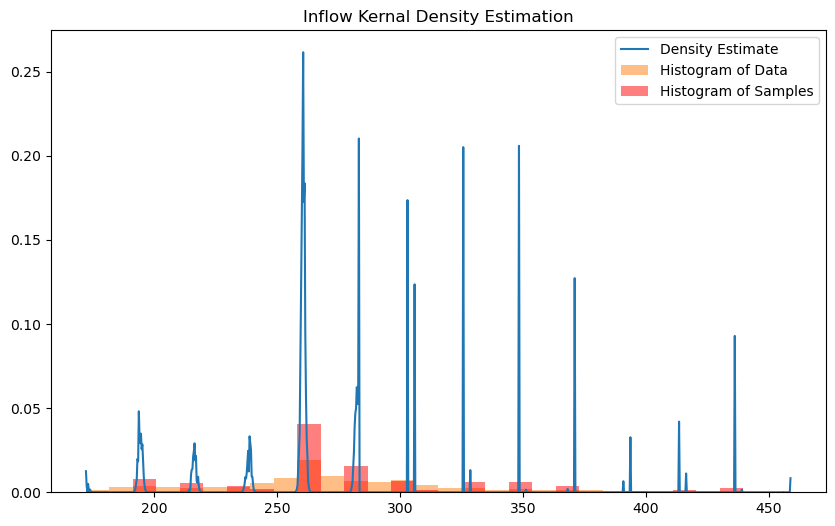

In [32]:
_, inflow_samples, _ = fit_logspline_density(df['Inflow'], n_samples, 'Inflow ', model=None, plot=True) 

In [37]:
reduced_n = len(df['SolarRad'][df['SolarRad'] != 0])

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: divide by zero encountered in log
  L += func(f_i)


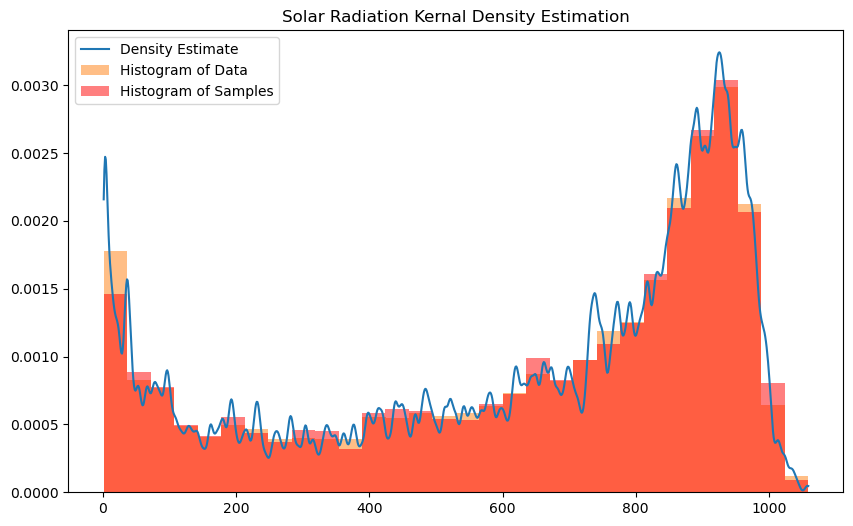

In [38]:
_, solar_samples, _ = fit_logspline_density(df['SolarRad'][df['SolarRad'] != 0], reduced_n, 'Solar Radiation ', model=None, plot=True) 

## Seasonal Data Extraction

In [21]:
def combine_monthdata(rad, inflow, price, month):
    rad_sub = rad[rad.Month == month]
    inflow_sub = inflow[inflow.datetime.dt.month == month] 
    price_sub = price[price.datetime.dt.month == month] 

    df = pd.DataFrame(columns=['datetime', 'Inflow', 'SolarRad', 'Price'])
    df['datetime'] = inflow_sub['datetime'].ravel()
    df['Inflow'] = inflow_sub['inflow'].ravel()
    df['SolarRad'] = rad_sub.DNI.ravel()
    df['Price'] =  price_sub['MW'].ravel()

    return df

In [51]:
dfjan = combine_monthdata(rad_2022, inflow_2022, price_df, 1)
dfapr = combine_monthdata(rad_2022, inflow_2022, price_df, 4)
dfjul = combine_monthdata(rad_2022, inflow_2022, price_df, 7)
dfoct = combine_monthdata(rad_2022, inflow_2022, price_df, 10)

In [177]:
dfjan.to_csv("output/jan2022.csv")
dfapr.to_csv("output/apr2022.csv")
dfjul.to_csv("output/jul2022.csv")
dfoct.to_csv("output/oct2022.csv")

In [39]:
df.to_csv("output/2022.csv")

In [24]:
df.head()

,datetime,Inflow,SolarRad,Price
0,2022-01-01 00:00:00,331.303978,0,57.11475
1,2022-01-01 01:00:00,314.314031,0,59.54397
2,2022-01-01 02:00:00,291.660767,0,56.55360
3,2022-01-01 03:00:00,267.591675,0,57.37142
4,2022-01-01 04:00:00,248.902733,0,59.34718


## Statistics

In [ ]:
# pairs: 0306_GLM
# mutual info: 0129_Intro_2

In [48]:
import seaborn as sns

### Pair Plots

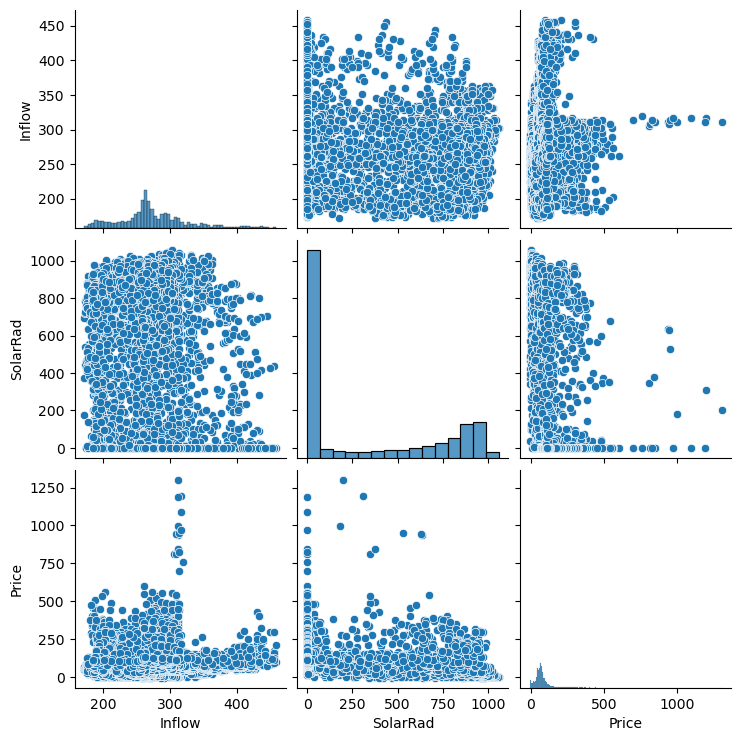

In [49]:
sns.pairplot(df)

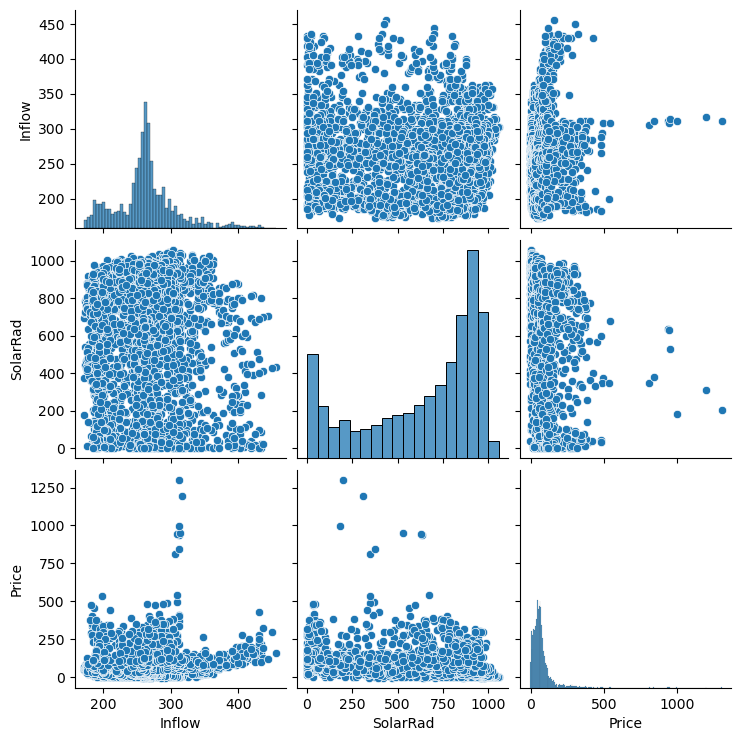

In [59]:
sns.pairplot(df[df.SolarRad != 0])

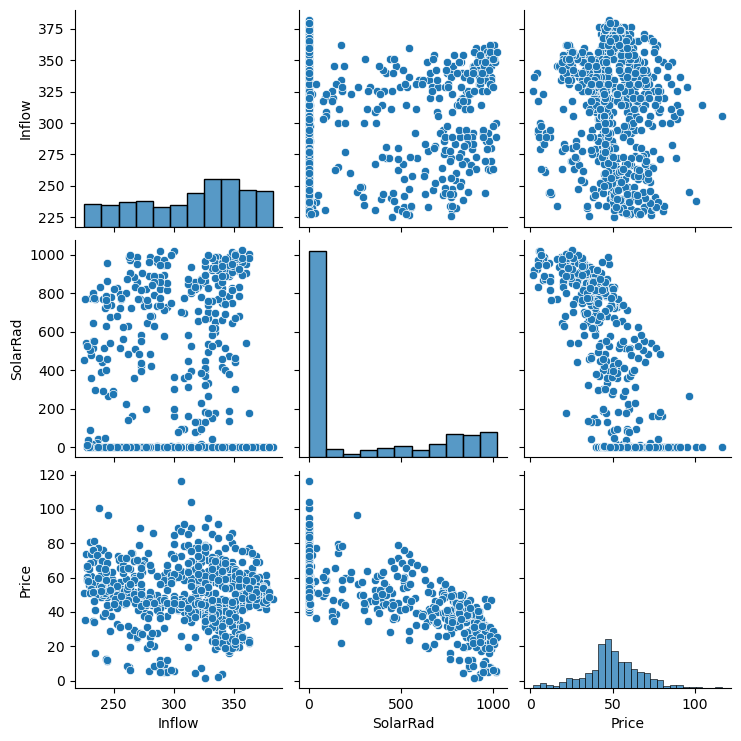

In [52]:
sns.pairplot(dfjan)

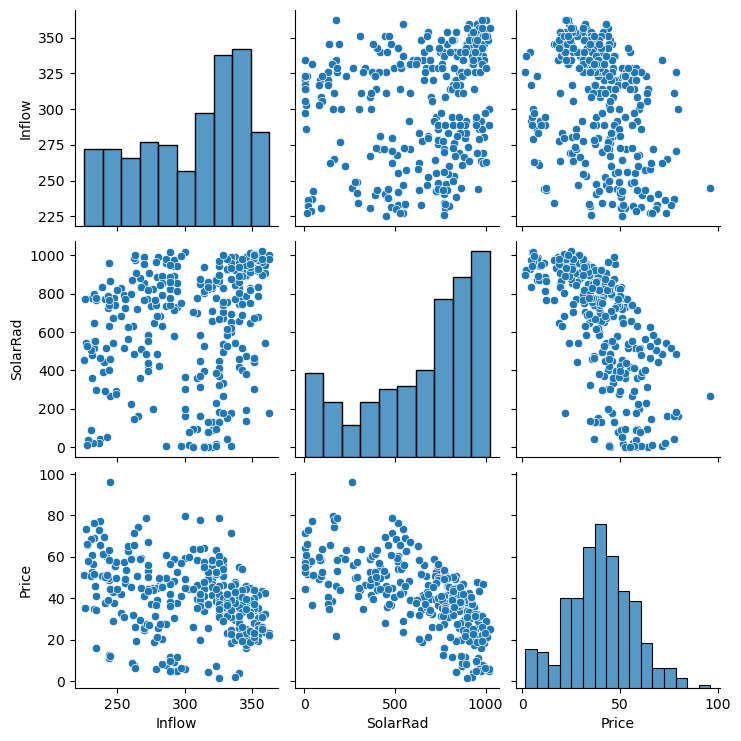

In [57]:
sns.pairplot(dfjan[dfjan.SolarRad != 0])

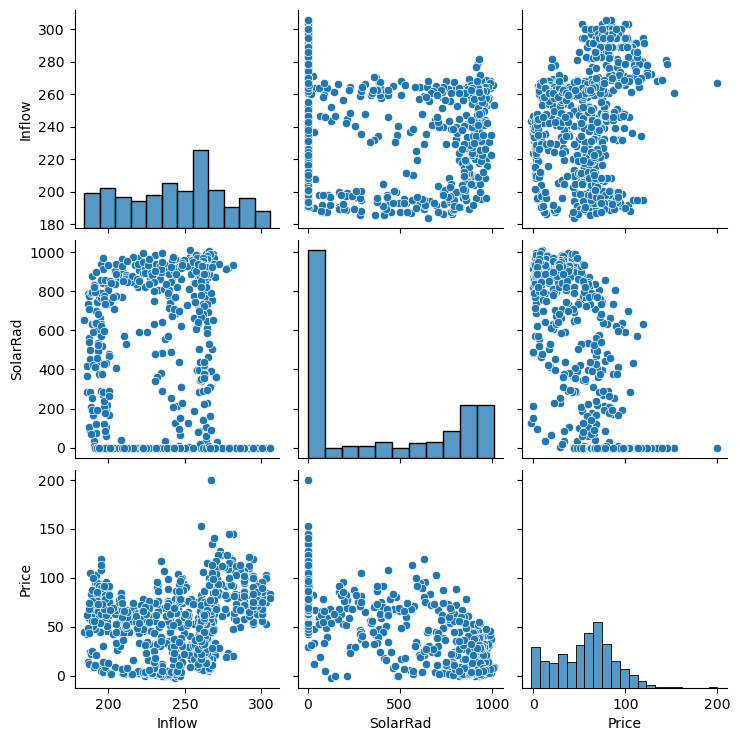

In [60]:
sns.pairplot(dfapr)

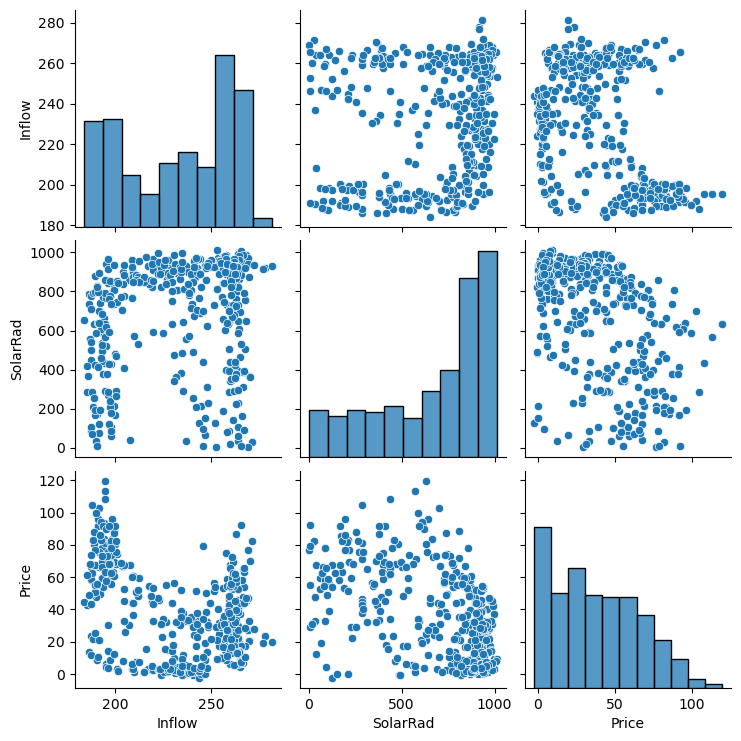

In [61]:
sns.pairplot(dfapr[dfapr.SolarRad != 0])

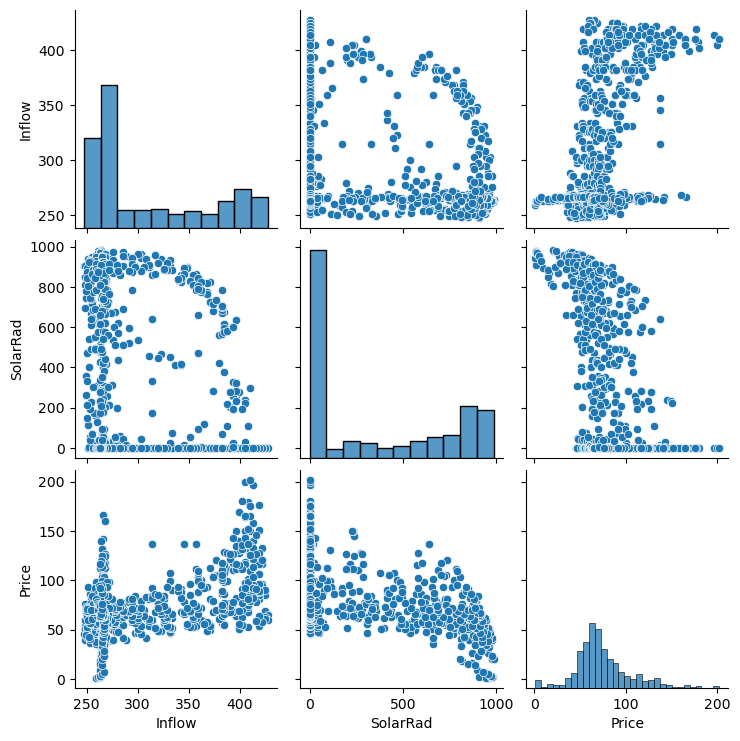

In [62]:
sns.pairplot(dfjul)

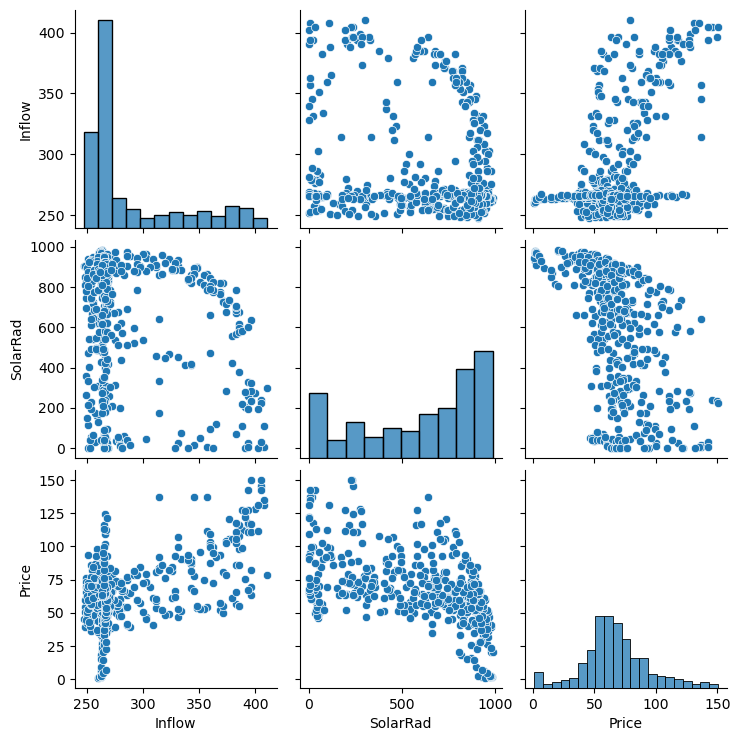

In [63]:
sns.pairplot(dfjul[dfjul.SolarRad != 0])

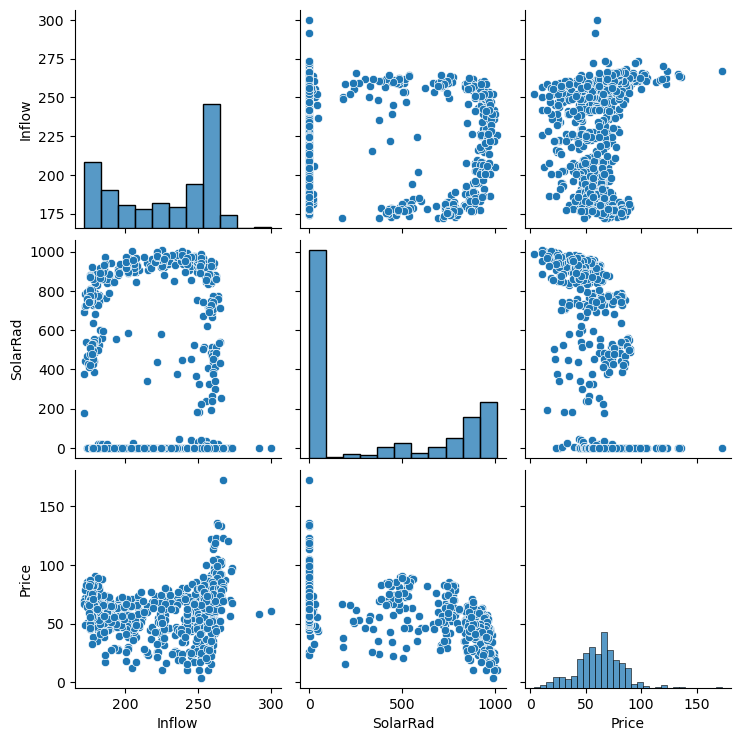

In [64]:
sns.pairplot(dfoct)

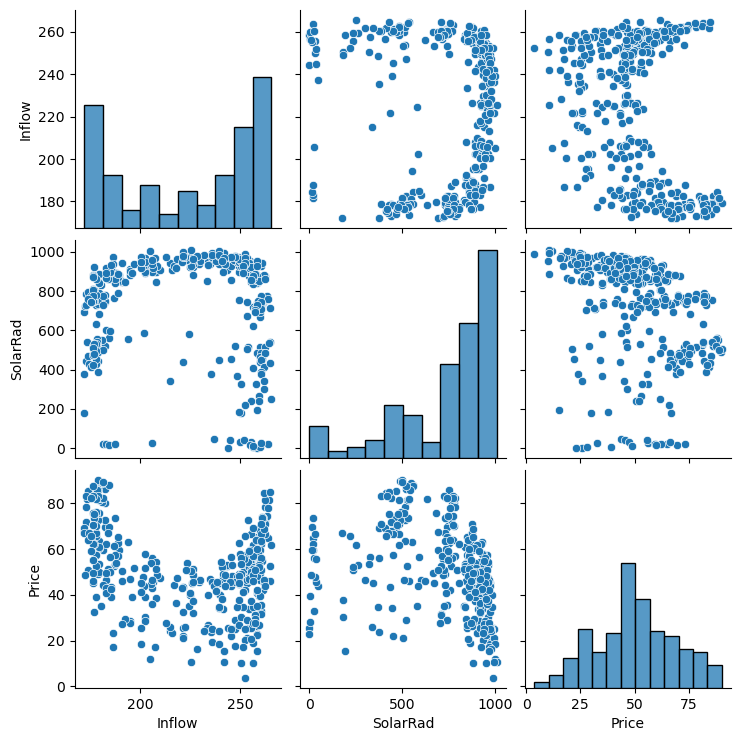

In [65]:
sns.pairplot(dfoct[dfoct.SolarRad != 0])

### Mutual Information

### Covariance

In [58]:
covariance_matrix = df.cov()
print(covariance_matrix)

               Inflow       SolarRad        Price
Inflow    2734.386474   -4061.240276   312.304202
SolarRad -4061.240276  152886.221726 -7908.398316
Price      312.304202   -7908.398316  6276.765915


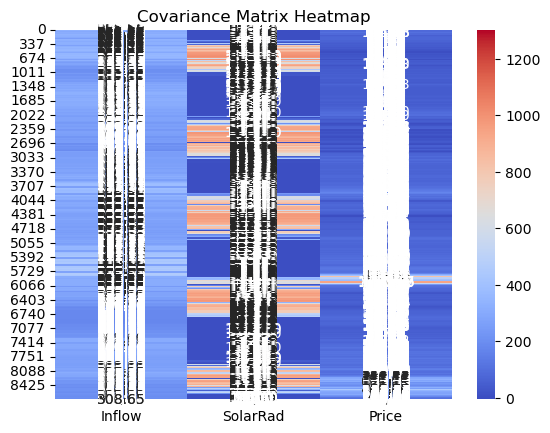

In [72]:
sns.heatmap(df[['Inflow', 'SolarRad', 'Price']], annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Covariance Matrix Heatmap")
plt.show()

In [66]:
covariance_matrix = df[df.SolarRad != 0].cov()
print(covariance_matrix)

               Inflow       SolarRad        Price
Inflow    1991.852264    -468.292677   376.010842
SolarRad  -468.292677  100865.707232 -7032.730710
Price      376.010842   -7032.730710  5446.579529


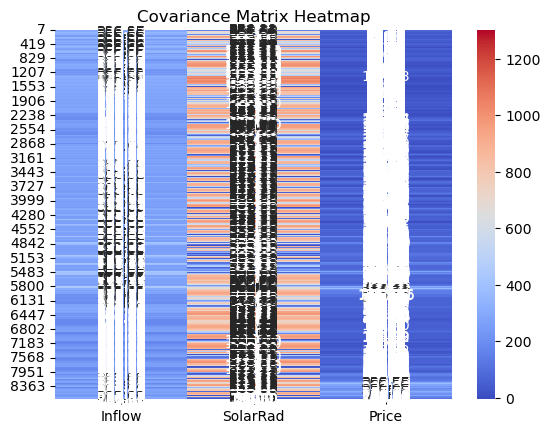

In [73]:
sns.heatmap(df[['Inflow', 'SolarRad', 'Price']][df.SolarRad != 0], annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Covariance Matrix Heatmap")
plt.show()